In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import feedparser
import concurrent.futures
import re
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import matplotlib.dates as mdates
from fpdf import FPDF
import os

In [24]:
# Odczytaj wartość zmiennej z pliku
with open('przekazana_zmienna.txt', 'r') as f:
    tresc=f.read()
    przekazana_zmienna = int(tresc.strip()[-2:]) if tresc.strip()[-2].isdigit() else int(tresc.strip()[-1])

# Odczytaj wartość zmiennej z pliku
with open('przekazany_tekst.txt', 'r') as f:
    przekazany_tekst = f.read().lower()

#usunięcie tymczasowych plików
os.remove('przekazana_zmienna.txt')
os.remove('przekazany_tekst.txt')


In [25]:

komisje={}

#Funkcja przetwarzająca pojedynczy wpis RSS.
def process_entry(entry):

    link = entry.link
    
    download_xml = requests.get(link)
    soup = BeautifulSoup(download_xml.text, 'html.parser')

    full_table = soup.find(class_='domino-richtext xspInputFieldRichText')
    if full_table:
        flag = 0
        licznik = 0
        autor = "" #autor wypowiedzi
        for x in full_table:
            if ":" in str(x.text) and "<b>" in str(x):
                flag = 1
                autor = x.text.replace(":", "")
            elif flag == 1 and "<b>" not in str(x):
                new = re.sub(r'[^\w\s]', '', x.text.lower())
                if przekazany_tekst in new:
                    licznik += 1
                    przyciety_tekst = entry.title.split('/')[0].strip().replace("[", "")
                    data=entry.title.split('(')[-1].split(')')[0]
                    if przyciety_tekst in komisje:
                        komisje[przyciety_tekst]+=1
                    else:
                        komisje[przyciety_tekst]=1
             
                    linki.append([autor,przyciety_tekst,data,link])

#link do kanału rss
link = "https://www.sejm.gov.pl/rss.nsf/feed.xsp?symbol=ZAPISY" if przekazana_zmienna == 10 else f"https://www.sejm.gov.pl/rss{przekazana_zmienna}.nsf/feed.xsp?symbol=ZAPISY"

NewsFeed = feedparser.parse(link)
linki = []

#wielowątkowosć
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_entry, entry) for entry in NewsFeed.entries]
    for future in concurrent.futures.as_completed(futures):
        pass



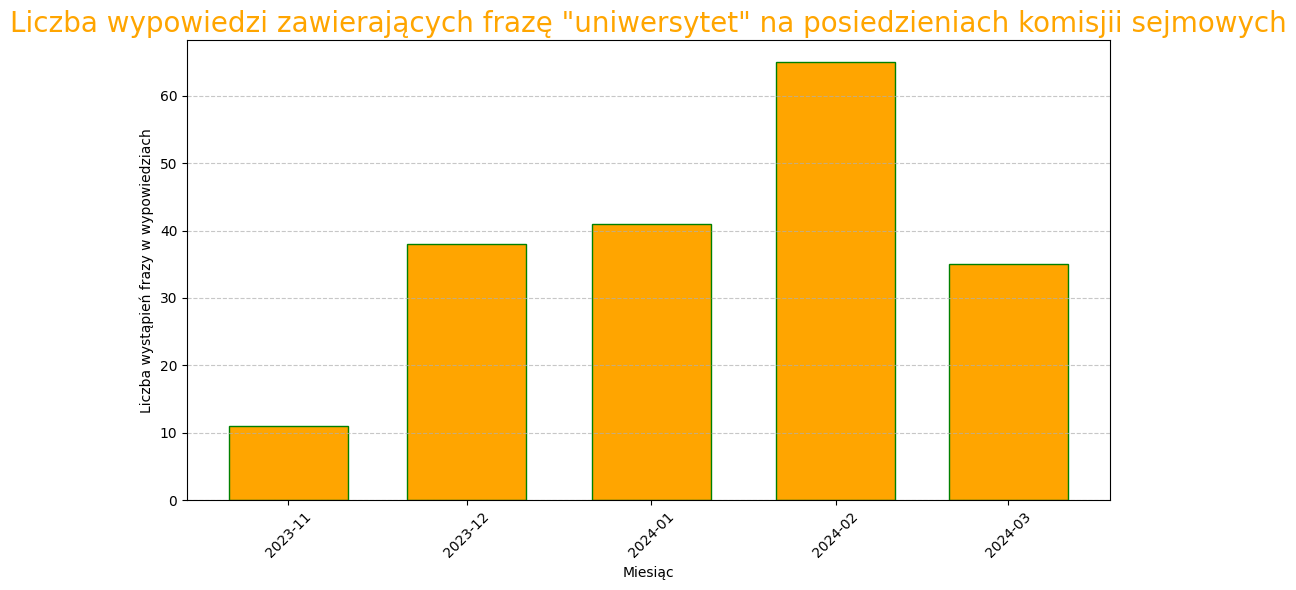

In [26]:

# daty wypowiedzi
daty = [datetime.strptime(x[2], "%d-%m-%Y") for x in linki]


# Słownik, gdzie kluczem jest miesiąc, a wartością jest liczba wystąpień w danym miesiącu
date_counts = defaultdict(int)
for date in daty:
    month_key = (date.year, date.month)
    date_counts[month_key] += 1

# Przygotowanie danych do wykresu
months = []
counts = []
for month_key in sorted(date_counts.keys()):
    months.append(datetime(month_key[0], month_key[1], 1))
    counts.append(date_counts[month_key])

# Tworzenie wykresu
plt.figure(figsize=(10, 6))
plt.bar(months, counts, color='orange', edgecolor='green', width=20)  # Dostosowanie szerokości słupków
plt.title(f"Liczba wypowiedzi zawierających frazę \"{przekazany_tekst}\" na posiedzieniach komisjii sejmowych", fontsize=20, color="orange")
plt.xlabel('Miesiąc')
plt.ylabel('Liczba wystąpień frazy w wypowiedziach')
plt.xticks(months, rotation=45)  # Ustawienie punktów na osi x co miesiąc
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formatowanie etykiet osi x
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Ustawienie znaczników co miesiąc
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Dostosowanie siatki tła
plt.tight_layout()

plt.savefig('wykres.png', bbox_inches='tight')

In [28]:

def header(text):
        pdf.set_text_color(255, 165, 0)
        pdf.set_font('Lato', 'B', 20)        
        pdf.cell(0, 10, text.upper(), align='C', ln=True)
        pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki
        pdf.set_text_color(0,0,0)

sorted_dict_values_reverse = sorted(komisje.items(), key=lambda x: x[1], reverse=True)  # Sortowanie po wartościach w odwrotnym porządku

df = pd.DataFrame(linki, columns =['Autor:', 'Komisja:', 'Data:',"Link:"]) #tabela z danymi
pdf = FPDF() #nowy pdf

pdf.add_font('lato', 'B', 'Lato-Bold.ttf')  # Dodanie niestandardowej czcionki
pdf.add_font('Lato', '', 'Lato-Regular.ttf')  # Dodanie niestandardowej czcionki
pdf.add_page()
pdf.set_font('Lato', '', 12)  # Ustawienie niestandardowej czcionki
tytul=['Autor','Komisja','Data','Link']
tytul2=['Komisja','Liczba wystąpień zwrotu']
# Tabela
header(f"{przekazana_zmienna} kadencja sejmu")
header("")
header("Wyszukiwana fraza na posiedzeniach komisjii:")
header(f"\"{przekazany_tekst}\"")
pdf.ln(10)

#informacja o niepełnych danych
if przekazana_zmienna==8:
     pdf.set_text_color(255, 0, 0)
     pdf.write(4,"\nDane dla 8 kadencji są niepełne i zawierają wyłącznie komisje, któe odbyły się po 15 października 2019!\n")
     pdf.set_text_color(0, 0, 0)

pdf.write(4,f"\nWyszukiwana fraza została wypowiedziana na komisjach sejmowych {len(linki)} razy.")

pdf.ln(10)
page_width = pdf.w - 2 * pdf.l_margin
pdf.image('wykres.png',w=page_width)


with pdf.table(text_align="CENTER", col_widths=(80, 20)) as table:
    row = table.row()  # Dodaj pierwszy wiersz
    for data_row in tytul2:
            pdf.set_fill_color(255, 165, 0)
            row.cell(data_row)
            pdf.set_fill_color(255, 255, 255)
    for key, value in sorted_dict_values_reverse:
        row = table.row()
        row.cell(str(key))
        row.cell(str(value))

header("")


with pdf.table(text_align="CENTER", col_widths=(80, 80, 40, 25)) as table:
    row = table.row()  # Dodaj pierwszy wiersz
    for data_row in tytul:
        pdf.set_fill_color(255, 165, 0)
        row.cell(data_row)
        pdf.set_fill_color(255, 255, 255)
    for _, data_row in df.iterrows():
        row = table.row()
        for i, datum in enumerate(data_row.tolist()):
            if i == 3:
                pdf.set_text_color(0, 0, 255)  # Ustaw kolor tekstu na niebieski
                row.cell(text="LINK",link=datum)
                pdf.set_text_color(0, 0, 0)  # Ustaw kolor tekstu na niebieski
            else:
                row.cell(datum)


# Zapisanie do pliku
pdf.output('plik.pdf')

%run zapis.ipynb

C:\Users\slowa\AppData\Local\Temp\ipykernel_14028\4071492349.py:13: DeprecationWarning: "uni" parameter is deprecated since v2.5.1, unused and will soon be removed
  pdf.add_font('lato', 'B', 'Lato-Bold.ttf', uni=True)  # Dodanie niestandardowej czcionki
C:\Users\slowa\AppData\Local\Temp\ipykernel_14028\4071492349.py:14: DeprecationWarning: "uni" parameter is deprecated since v2.5.1, unused and will soon be removed
  pdf.add_font('Lato', '', 'Lato-Regular.ttf', uni=True)  # Dodanie niestandardowej czcionki
C:\Users\slowa\AppData\Local\Temp\ipykernel_14028\4071492349.py:4: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, text.upper(), align='C', ln=True)
